# Proximal Policy Optimization (PPO)

## Importing libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy
import time
from IPython.display import display, clear_output

import gymnasium as gym

from collections import defaultdict, deque
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import *
from utils.models import MLP, MLPPolicyDiscrete, MLPPolicyGaussianFixedVariance

## Config

In [2]:
CONFIG = {
    'PPO': {
        'CartPole-v1': {
            'gamma': 0.99, 
            'total_steps': 100_000,
            'steps_per_batch': 1024, 
            'policy_lr': 1e-3,
            'val_fn_lr': 5e-4, 
            'num_epochs': 10,
            'epsilon': 0.2,      
            'val_fn_hidden_sizes': [64,64],
        },
        'LunarLander-v3': {
            'gamma': 0.99, 
            'total_steps': 500_000,
            'steps_per_batch': 3200, 
            'policy_lr': 1e-3,
            'val_fn_lr': 5e-4, 
            'num_epochs': 10,
            'epsilon': 0.2,      
            'val_fn_hidden_sizes': [64,64],
        },
        'Pendulum-v1': {
            'gamma': 0.99, 
            'total_steps': 500_000,
            'steps_per_batch': 1000, 
            'policy_lr': 3e-4,
            'val_fn_lr': 1e-3, 
            'num_epochs': 10,
            'epsilon': 0.2,      
            'val_fn_hidden_sizes': [64,64],
        },
    },
    'MLPPolicy_hidden_sizes': [64,64],
    'animation': {
        'FPS': 45,
        'do_truncate': True,
    },
    'plots_info': {
        'subplt_shape': (1,2),
        'figsize': (12,4),
        'subplts_info': [
            {'key': "rewards",
            'title': "Smoothed Rewards",
            'xlabel': "Episodes",
            'ylabel': "Reward"},
            
            {'key': "ppo_loss",
            'title': "Smooth PPO Loss",
            'xlabel': "Timesteps",
            'ylabel': "Loss"}
        ],
    },
}

## Creating the environments

In [3]:
cartpole_env = gym.make('CartPole-v1', render_mode = 'rgb_array')
lunar_env = gym.make('LunarLander-v3', render_mode = 'rgb_array')

pendulum_env = gym.make('Pendulum-v1', render_mode = 'rgb_array')

## Proximal Policy Optimization 

In [4]:
def PPO(env, policy, gamma = 0.99,
         total_steps = 1e6, steps_per_batch = 2048,
         policy_lr = 1e-3, val_fn_lr = 1e-3, num_epochs = 10,
         epsilon = 0.2, val_fn_hidden_sizes = [16]):

    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
    if isinstance(env.action_space, gym.spaces.Discrete):
        is_discrete = True
        s_dims = env.observation_space.shape[0]
        a_dims = env.action_space.n
    elif isinstance(env.action_space, gym.spaces.Box):
        is_discrete = False
        s_dims = env.observation_space.shape[0]
        a_dims = env.action_space.shape[0]
    else:
        raise NotImplementedError(f"Unsupported action space {type(env.action_space)}")
    
    stats = {'ep_length': [],
             'rewards': [],
             'completions': 0,
             'ppo_loss': [],
             'val_loss': [],
             'n_iters': 0}
    
    value_fn = MLP(s_dims, 1, val_fn_hidden_sizes)
    mse_loss = nn.MSELoss()
    
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr = policy_lr)
    value_optimizer = torch.optim.Adam(value_fn.parameters(), lr = val_fn_lr)
    
    
    n_steps = 0
    n_iters = 0
    e = 0
    print(f'\rStep : 0/{total_steps} (0.00%)', end = '')
    while n_steps <= total_steps:
        
        H = defaultdict(lambda: [])
        t=0
        num_eps = 0
        r_sum = 0.0
        while t <= steps_per_batch:
            H['episode_rewards'].append([])
            
            s, _ = env.reset()
            T = 0
            stats['rewards'] += [0.0]
            while True:
                if is_discrete: 
                    probs = policy(torch.as_tensor(s))
                    dist =  torch.distributions.Categorical(probs)
                    a = dist.sample().item()
                    a_np = a
                    log_prob = dist.log_prob(torch.tensor(a))
                else:   
                    mu, var = policy(torch.as_tensor(s))
                    dist = torch.distributions.MultivariateNormal(mu, torch.diag(var))
                    a = dist.sample()
                    a_np = a.detach().numpy()
                    log_prob = dist.log_prob(a)
                
                s_n, r, terminated, truncated, info = env.step(a_np)
                
                t += 1
                T += 1
                r = float(r)
                
                H['s'] += [s]
                H['a'] += [a]
                H['episode_rewards'][-1] += [r]
                H['s_n'] += [s_n]
                H['log_prob'] += [log_prob]
        
                stats['rewards'][-1] += r

                if terminated or truncated:
                    stats['ep_length'] += [T]
                    
                    if truncated:
                        stats['completions'] += 1

                    num_eps += 1
                    r_sum += stats['rewards'][-1]
                    break
                    
                s = s_n

        # The batch has been collected into H
        n_steps += t
        n_iters += 1
        stats['n_iters'] = n_iters
        avg_rsum = r_sum /num_eps
        
        states_tensor = torch.as_tensor(np.asarray(H['s']))
        next_states_tensor = torch.as_tensor(np.asarray(H['s_n']))
        actions_tensor = torch.as_tensor(np.asarray(H['a']))
        lprobs_tensor = torch.stack(H['log_prob']).detach()

        Rt_tensor = []
        for rewards in reversed(H['episode_rewards']):
            R = 0
            for r in reversed(rewards):
                R = r + gamma * R
                Rt_tensor.insert(0,R)
                
        Rt_tensor = torch.tensor(Rt_tensor)
        Rt_tensor = (Rt_tensor - Rt_tensor.mean()) / (Rt_tensor.std() + 1e-8)
        
        adv_tensor = Rt_tensor - value_fn(states_tensor).detach()
        adv_tensor = (adv_tensor - adv_tensor.mean()) / (adv_tensor.std() + 1e-8)
                    
        total_ppo_loss = 0.0
        total_val_loss = 0.0
        for epoch in range(num_epochs):
            
            V = value_fn(states_tensor).view(-1)
            
            val_loss = mse_loss(V, Rt_tensor)
            total_val_loss += val_loss.item()
            
            value_optimizer.zero_grad()
            val_loss.backward()
            value_optimizer.step()

            
            if is_discrete:
                probs = policy(states_tensor)
                dist = torch.distributions.Categorical(probs)
                new_lprobs = dist.log_prob(actions_tensor)
                dist_entropy = dist.entropy().mean()
            else:
                mu, var = policy(states_tensor)
                dist = torch.distributions.MultivariateNormal(mu, torch.diag_embed(var))
                new_lprobs = dist.log_prob(actions_tensor)
                dist_entropy = dist.entropy().mean()
                
            ratios = torch.exp(new_lprobs - lprobs_tensor)
            clipped_ratios = torch.clamp(ratios, 1 - epsilon, 1 + epsilon)
            ppo_loss = -torch.min(ratios * adv_tensor, clipped_ratios * adv_tensor).mean() - 0.0 * dist_entropy
            total_ppo_loss += ppo_loss.item()

            policy_optimizer.zero_grad()
            ppo_loss.backward()
            policy_optimizer.step()

            
        stats['val_loss'] += [total_val_loss/num_epochs]
        stats['ppo_loss'] += [total_ppo_loss/num_epochs]
        
        sys.stdout.flush()

        if n_steps % 1 == 0 or n_steps >= total_steps:
            print(f'\rStep : {n_steps}/{total_steps} ({100*n_steps/total_steps:.2f}%) -- Reward : {avg_rsum:.2f}', end = '')
    
    return stats

## CartPole

In [5]:
s_dims = cartpole_env.observation_space.shape[0]
a_dims = cartpole_env.action_space.n

cartpole_policy = MLPPolicyDiscrete(s_dims, a_dims, CONFIG['MLPPolicy_hidden_sizes'])
cartpole_stats = PPO(cartpole_env, cartpole_policy, **CONFIG['PPO']['CartPole-v1'])

Step : 100197/100000 (100.20%) -- Reward : 428.33

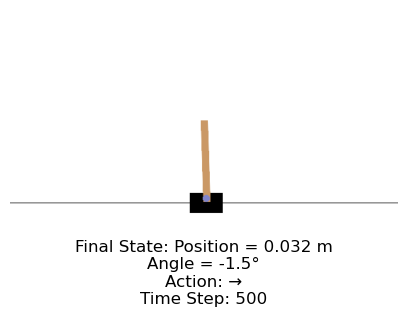

In [6]:
animate_policy(cartpole_env, cartpole_policy, None, True)

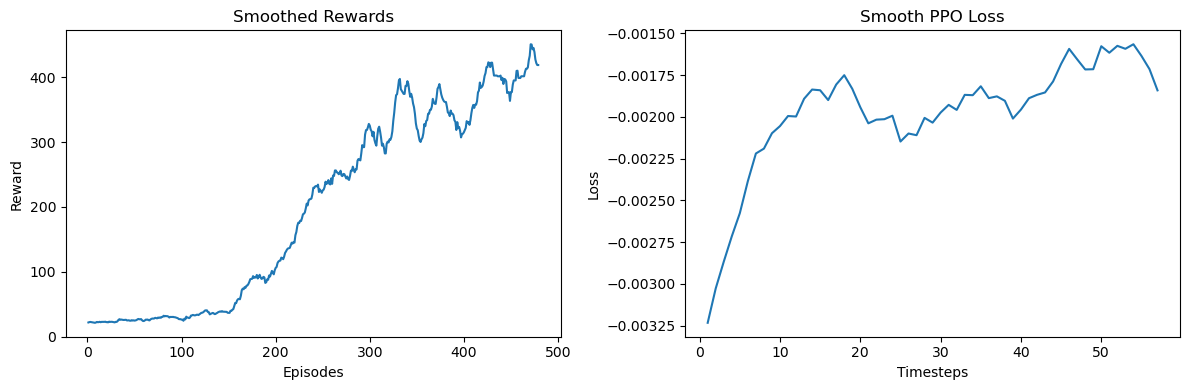

In [10]:
plots.plot_stats(cartpole_stats, CONFIG['plots_info'], 25)

## LunarLander

In [11]:
s_dims = lunar_env.observation_space.shape[0]
a_dims = lunar_env.action_space.n

lunar_policy = MLPPolicyDiscrete(s_dims, a_dims, CONFIG['MLPPolicy_hidden_sizes'])
lunar_stats = PPO(lunar_env, lunar_policy, **CONFIG['PPO']['LunarLander-v3'])

Step : 500767/500000 (100.15%) -- Reward : 83.785

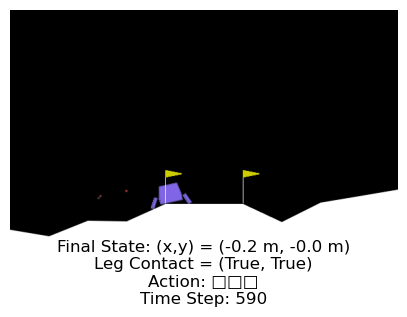

In [12]:
animate_policy(lunar_env, lunar_policy, **CONFIG['animation'])

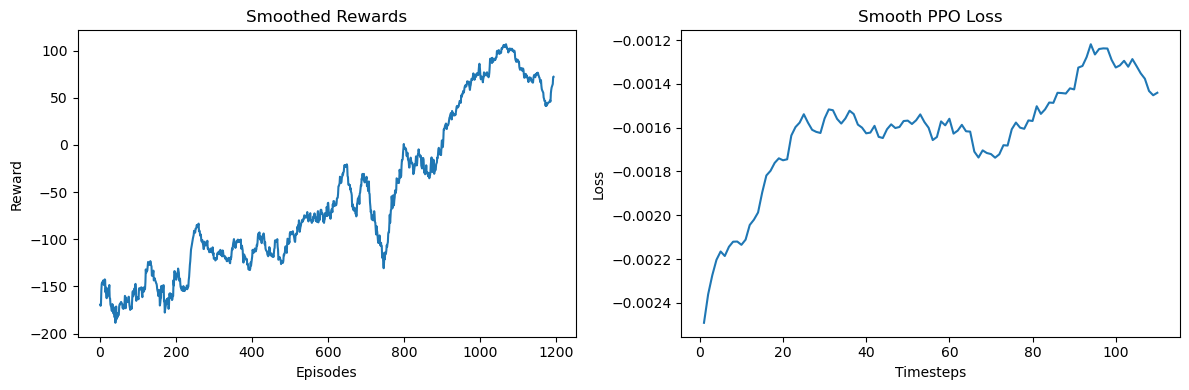

In [16]:
plots.plot_stats(lunar_stats, CONFIG['plots_info'])

## Pendulum

In [17]:
s_dims = pendulum_env.observation_space.shape[0]
a_dims = pendulum_env.action_space.shape[0]

pendulum_policy = MLPPolicyGaussianFixedVariance(s_dims, a_dims, CONFIG['MLPPolicy_hidden_sizes'])
pendulum_stats = PPO(pendulum_env, pendulum_policy, **CONFIG['PPO']['Pendulum-v1'])

Step : 500400/500000 (100.08%) -- Reward : -989.36

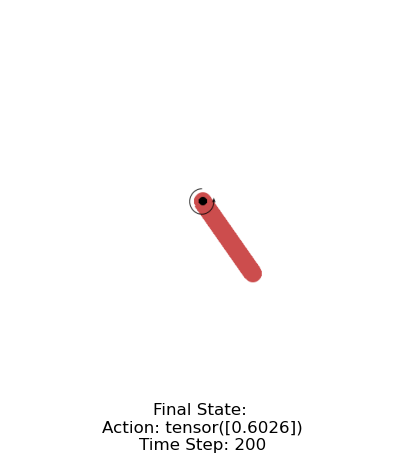

In [18]:
plots.animate_policy(pendulum_env, pendulum_policy, **CONFIG['animation'])

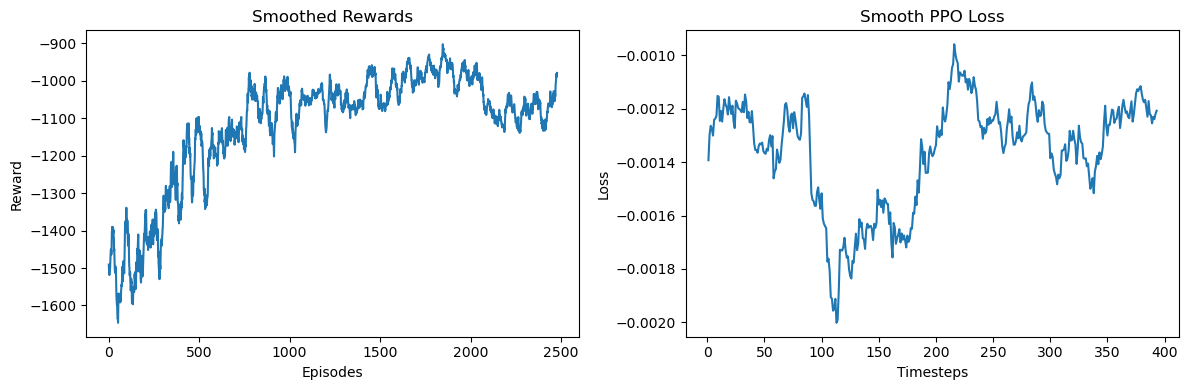

In [20]:
plots.plot_stats(pendulum_stats, CONFIG['plots_info'])